## Семинар 3 "Определение ключевых точек лица"

Кафанов Олег Игоревич

# Подготовительная задача 1

Сделать из линейной регрессии nn.sequental двухслойную сеть

In [1]:
import torch
from torch import nn

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from torch.autograd import Variable
%matplotlib inline

In [3]:
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:
X_train = []
y_train = []
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X_train += [X] 
    y_train += [y]
    

In [5]:
X_test = []
y_test = []
for X, y in test_loader:
    X = X.view(X.size(0), -1)
    X_test += [X] 
    y_test += [y]

In [6]:
X_train = torch.cat(X_train)
y_train = torch.cat(y_train)

In [7]:
X_test = torch.cat(X_test)
y_test = torch.cat(y_test)

In [8]:
def shuffle_tensors (tensor1, tensor2):
    shuffle_indexes = torch.randperm(tensor1.shape[0])
    return tensor1[shuffle_indexes,...], tensor2[shuffle_indexes]

In [9]:
#model = nn.Sequential(nn.Linear(784, 100), nn.Sigmoid(), nn.Linear(100, 100), nn.Sigmoid(), nn.Linear(100, 10), nn.LogSoftmax())

In [10]:
import random

In [11]:
def learn_network(model, X_train, y_train, X_test, y_test):
    model.cuda()
    n_epoch = 2
    batch_size = 32
    learning_rate = 1e-3

    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_list = []
    loss_list_test = []
    i = 0

    for epoch in range(n_epoch):
        print 'EPOCH', epoch
        for i in range(0, len(X_train), batch_size):
            x = Variable(X_train[i:i + batch_size].type(torch.cuda.FloatTensor))
            y = Variable(y_train[i:i + batch_size].type(torch.cuda.LongTensor))        

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            
            sample = random.sample(range(len(X_test)),25)
            x_t = Variable(X_test[torch.from_numpy(np.array(sample)),...].type(torch.cuda.FloatTensor))
            y_t = Variable(y_test[torch.from_numpy(np.array(sample))].type(torch.cuda.LongTensor))
            
            y_pred_test = model(x_t)
            loss_test = loss_fn(y_pred_test, y_t)
            loss_list_test += [loss_test.data.mean()]
            
            if i%10000 == 0:
                print i, loss.data.mean()
            i += 1
            loss_list += [loss.data.mean()]

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        X_train, y_train = shuffle_tensors(X_train, y_train)
    return loss_list, loss_list_test

In [12]:
def precision(X_test, y_test):
    true = 0.
    false = 0.

    x = Variable(X_test.type(torch.cuda.FloatTensor))    
    y_pred = model(x)

    for i in y_pred.data.type(torch.FloatTensor).numpy().argmax(axis = 1) - y_test.numpy().T:
        if i:
            false += 1
        else:
            true += 1

    print true/(true + false)

# Подготовительная задача 2

Используя структуру сети Sequental в pytorch реализовать и обучить классификатор цифр из MNIST
(повторить первый и второй пункты из прошлого задания )

## Sigmoid

In [13]:
model = nn.Sequential(nn.Linear(784, 100), nn.Sigmoid(), nn.Linear(100, 100), nn.Sigmoid(), nn.Linear(100, 10), nn.LogSoftmax())

In [14]:
loss_list_sig, loss_list_sig_test = learn_network(model, X_train, y_train, X_test, y_test)

EPOCH 0
0 2.3753361702
20000 0.268390983343
40000 0.194073691964
EPOCH 1
0 0.139749959111
20000 0.157894209027
40000 0.307732194662


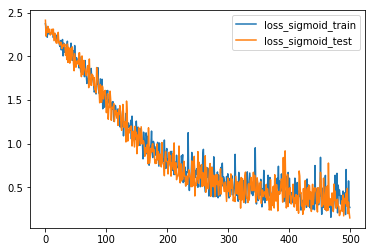

In [15]:
plt.plot(loss_list_sig[:500], label='loss_sigmoid_train')
plt.plot(loss_list_sig_test[:500], label='loss_sigmoid_test')
plt.legend()
plt.show()

In [16]:
precision(X_test, y_test)

0.9627


## ReLU

In [17]:
model = nn.Sequential(nn.Linear(784, 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 10), nn.LogSoftmax())

In [18]:
loss_list_relu, loss_list_relu_test = learn_network(model, X_train, y_train, X_test, y_test)

EPOCH 0
0 2.33201432228
20000 0.0486203208566
40000 0.0879089534283
EPOCH 1
0 0.0948135480285
20000 0.0370161980391
40000 0.0573387145996


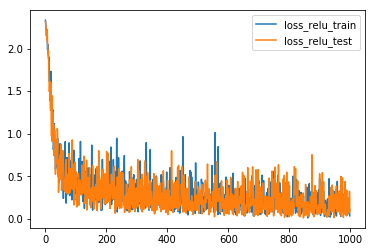

In [19]:
plt.plot(loss_list_relu[:1000], label='loss_relu_train')
plt.plot(loss_list_relu_test[:1000], label='loss_relu_test')
plt.legend()
plt.show()

In [20]:
precision(X_test, y_test)

0.9663


## ELU

In [21]:
model = nn.Sequential(nn.Linear(784, 100), nn.ELU(), nn.Linear(100, 100), nn.ELU(), nn.Linear(100, 10), nn.LogSoftmax())

In [22]:
loss_list_elu, loss_list_elu_test = learn_network(model, X_train, y_train, X_test, y_test)

EPOCH 0
0 2.31159305573
20000 0.0559518486261
40000 0.0599915459752
EPOCH 1
0 0.171082377434
20000 0.0360650420189
40000 0.0123636871576


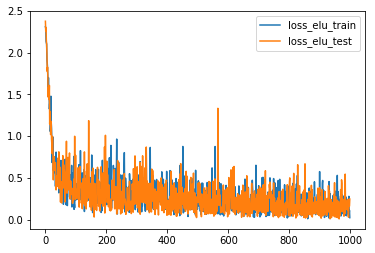

In [23]:
plt.plot(loss_list_elu[:1000], label='loss_elu_train')
plt.plot(loss_list_elu_test[:1000], label='loss_elu_test')
plt.legend()
plt.show()

In [24]:
precision(X_test, y_test)

0.9683


# Сравнение

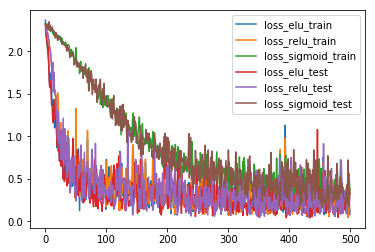

In [45]:
plt.plot(loss_list_elu[:500], label='loss_elu_train')
plt.plot(loss_list_relu[:500], label='loss_relu_train')
plt.plot(loss_list_sig[:500], label='loss_sigmoid_train')
plt.plot(loss_list_elu_test[:500], label='loss_elu_test')
plt.plot(loss_list_relu_test[:500], label='loss_relu_test')
plt.plot(loss_list_sig_test[:500], label='loss_sigmoid_test')
plt.legend()
plt.show()

## Вывод 1

Сигмоид сходится медленнее, так как производная вне окрестности нуля очень мала <br/>
ReLU и ELU сошлись быстрее, так как производная вне окрестности нуля велика

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[  7.  41.]
 [  8.  51.]
 [ 10.  60.]
 [ 13.  70.]]


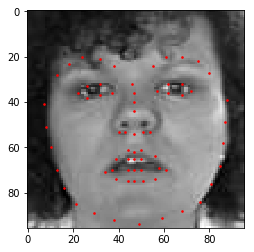

In [47]:
%matplotlib inline
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    #plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001) 

#plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),landmarks)
plt.show()

In [48]:
X_train = []
y_train = []
for n in range(landmarks_frame.shape[0]):
    img_name = landmarks_frame.ix[n, 0]
    landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
    y_train += [landmarks.reshape(-1, 2)]
    X_train += [io.imread(os.path.join('dataset/train/', img_name))]

In [49]:
landmarks_frame_test = pd.read_csv('dataset/test/face_landmarks.csv')
X_test = []
y_test = []
for n in range(landmarks_frame_test.shape[0]):
    img_name = landmarks_frame_test.ix[n, 0]
    landmarks = landmarks_frame_test.ix[n, 1:].as_matrix().astype('float')
    y_test += [landmarks.reshape(-1, 2)]
    X_test += [io.imread(os.path.join('dataset/test/', img_name))]

In [50]:
X_train_new = []
for X in X_train:
    X_train_new += [X.reshape(-1,1).T]
    #X_train_new += [X]
X_train_new = np.concatenate(X_train_new)

In [51]:
y_train_new = []
for y in y_train:
    y_train_new += [y.reshape(-1,1).T]
y_train_new = np.concatenate(y_train_new)

In [52]:
X_train_new.shape

(6221, 9216)

In [53]:
y_train_new.shape

(6221, 136)

In [54]:
X_train = torch.from_numpy(X_train_new)
y_train = torch.from_numpy(y_train_new)

In [55]:
X_test_new = []
for X in X_test:
    X_test_new += [X.reshape(-1,1).T]
X_test_new = np.concatenate(X_test_new)

In [56]:
y_test_new = []
for y in y_test:
    y_test_new += [y.reshape(-1,1).T]
y_test_new = np.concatenate(y_test_new)

In [57]:
X_test = torch.from_numpy(X_test_new)
y_test = torch.from_numpy(y_test_new)

In [58]:
def im_show(X_test, N):
    i = 1
    for k in range(N):
        image = X_test[k].numpy().reshape(96,96)
        landmarks = model(Variable(X_test[k].type(torch.cuda.FloatTensor))).type(torch.FloatTensor).data.numpy().reshape(-1,2)

        plt.subplot(3, 3, i)
        i += 1
        plt.imshow(image, cmap='gray')
        plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
        plt.axis('off')

        if i == 10:
            plt.show()
            i = 1

In [73]:
def learn_network(model, X_train, y_train, X_test, y_test, learning_rate, n_epoch):
    model.cuda()
    #n_epoch = 15
    batch_size = 25

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_list = []
    loss_list_test = []
    i = 0

    for epoch in range(n_epoch):
        print ('EPOCH', epoch)
        for i in range(0, len(X_train) - 1, batch_size):
            x = Variable(X_train[i:i + batch_size].type(torch.cuda.FloatTensor))
            y = Variable(y_train[i:i + batch_size].type(torch.cuda.FloatTensor))        

            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            sample = random.sample(range(len(X_test)),25)
            x_t = Variable(X_test[torch.from_numpy(np.array(sample)),...].type(torch.cuda.FloatTensor))
            y_t = Variable(y_test[torch.from_numpy(np.array(sample))].type(torch.cuda.FloatTensor))
            
            y_pred_test = model(x_t)
            loss_test = loss_fn(y_pred_test, y_t)
            loss_list_test += [loss_test.data.mean()]
            
            if i%10000 == 0:
                print (i, loss.data.mean())
            i += 1
            loss_list += [loss.data[0]]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        X_train, y_train = shuffle_tensors(X_train, y_train)
    return loss_list, loss_list_test

In [60]:
def loss(X_test, y_test):
    loss_fn = torch.nn.MSELoss()
    return loss_fn(model(Variable(X_test.type(torch.cuda.FloatTensor))), Variable(y_test.type(torch.cuda.FloatTensor)))

# ELU 2

In [64]:
model = nn.Sequential(nn.Linear(9216, 200), nn.ELU(), nn.Linear(200, 136), nn.ELU(), nn.Linear(136, 136))

In [65]:
loss_list_elu, loss_list_elu_test = learn_network(model, X_train, y_train, X_test, y_test, 1e-3, 15)

EPOCH 0
0 3428.21240234
EPOCH 1
0 147.32850647
EPOCH 2
0 145.637771606
EPOCH 3
0 111.917747498
EPOCH 4
0 93.9111785889
EPOCH 5
0 41.0300331116
EPOCH 6
0 26.8502483368
EPOCH 7
0 19.9360103607
EPOCH 8
0 10.7792053223
EPOCH 9
0 9.38551235199
EPOCH 10
0 9.18861293793
EPOCH 11
0 13.2723884583
EPOCH 12
0 13.2614994049
EPOCH 13
0 7.26176261902
EPOCH 14
0 7.00982999802


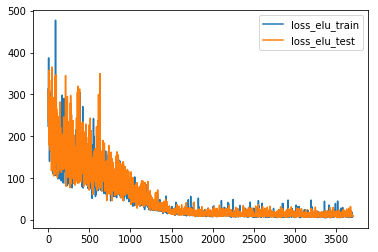

In [68]:
plt.plot(loss_list_elu[30:], label='loss_elu_train')
plt.plot(loss_list_elu_test[30:], label='loss_elu_test')
plt.legend()
plt.show()

In [69]:
loss(X_test, y_test)

Variable containing:
 12.4769
[torch.cuda.FloatTensor of size 1 (GPU 0)]

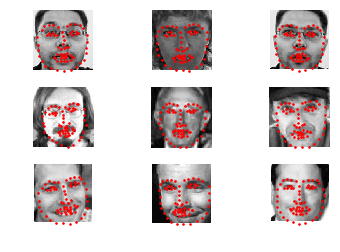

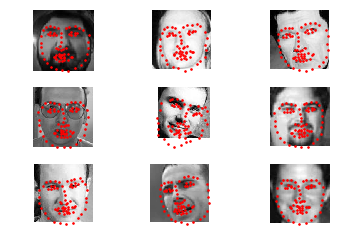

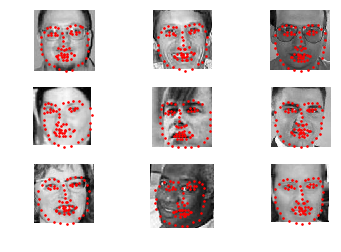

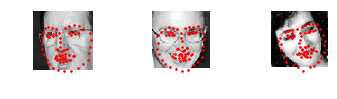

In [70]:
im_show(X_test, 30)

## 7 эпох

In [71]:
model = nn.Sequential(nn.Linear(9216, 200), nn.ELU(), nn.Linear(200, 136), nn.ELU(), nn.Linear(136, 136))

In [74]:
loss_list_elu, loss_list_elu_test = learn_network(model, X_train, y_train, X_test, y_test, 1e-3, 7)

EPOCH 0
0 3710.53344727
EPOCH 1
0 183.834579468
EPOCH 2
0 116.542358398
EPOCH 3
0 78.3190841675
EPOCH 4
0 36.4713134766
EPOCH 5
0 22.4686813354
EPOCH 6
0 13.8382377625


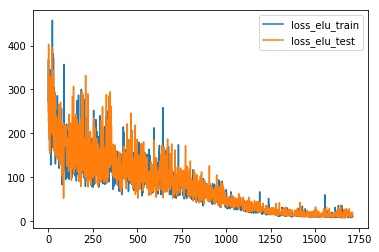

In [75]:
plt.plot(loss_list_elu[30:], label='loss_elu_train')
plt.plot(loss_list_elu_test[30:], label='loss_elu_test')
plt.legend()
plt.show()

In [76]:
loss(X_test, y_test)

Variable containing:
 14.2118
[torch.cuda.FloatTensor of size 1 (GPU 0)]

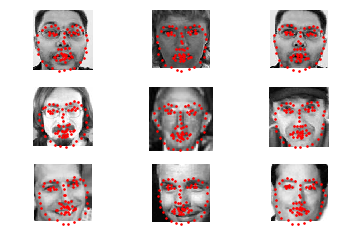

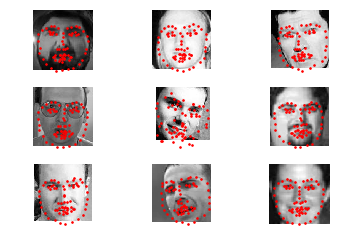

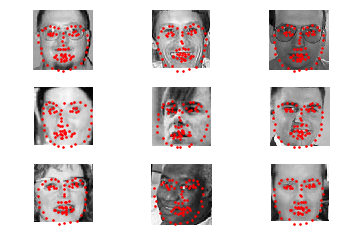

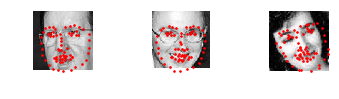

In [77]:
im_show(X_test, 30)

# ReLU 2

In [78]:
model = nn.Sequential(nn.Linear(9216, 200), nn.ReLU(), nn.Linear(200, 136), nn.ReLU(), nn.Linear(136, 136))

In [79]:
loss_list_relu, loss_list_relu_test = learn_network(model, X_train, y_train, X_test, y_test, 1e-3, 8)

EPOCH 0
0 3317.13598633
EPOCH 1
0 271.336761475
EPOCH 2
0 106.444374084
EPOCH 3
0 115.398513794
EPOCH 4
0 145.394561768
EPOCH 5
0 120.730278015
EPOCH 6
0 222.097579956
EPOCH 7
0 229.165939331


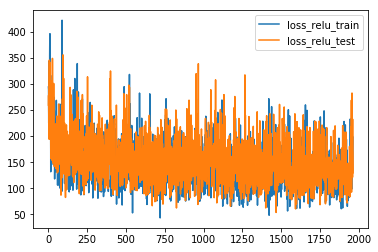

In [80]:
plt.plot(loss_list_relu[30:], label='loss_relu_train')
plt.plot(loss_list_relu_test[30:], label='loss_relu_test')
plt.legend()
plt.show()

In [81]:
loss(X_test, y_test)

Variable containing:
 149.6646
[torch.cuda.FloatTensor of size 1 (GPU 0)]

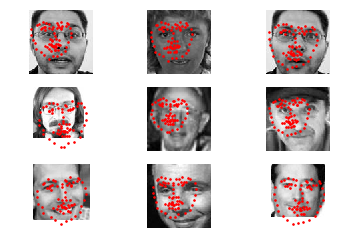

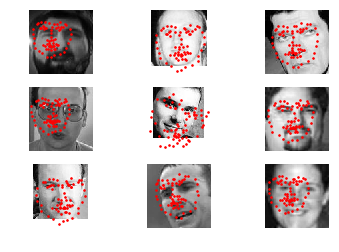

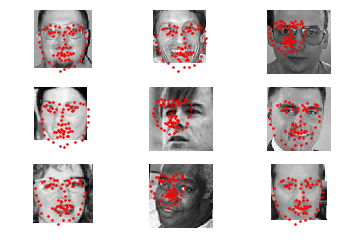

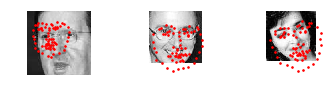

In [82]:
im_show(X_test, 30)

# Sigmoid 2

In [83]:
model = nn.Sequential(nn.Linear(9216, 200), nn.Sigmoid(), nn.Linear(200, 136), nn.Sigmoid(), nn.Linear(136, 136))

In [84]:
loss_list_sig, loss_list_sig_test = learn_network(model, X_train, y_train, X_test, y_test, 1e-3, 8)

EPOCH 0
0 3174.21508789
EPOCH 1
0 885.648132324
EPOCH 2
0 213.014968872
EPOCH 3
0 57.4334449768
EPOCH 4
0 21.5880393982
EPOCH 5
0 16.9432315826
EPOCH 6
0 18.2611885071
EPOCH 7
0 17.7281513214


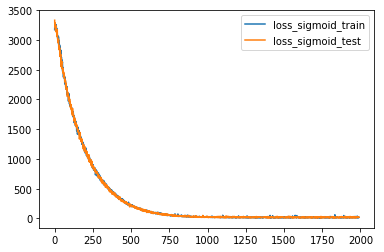

In [85]:
plt.plot(loss_list_sig, label='loss_sigmoid_train')
plt.plot(loss_list_sig_test, label='loss_sigmoid_test')
plt.legend()
plt.show()

In [86]:
loss(X_test, y_test)

Variable containing:
 18.5147
[torch.cuda.FloatTensor of size 1 (GPU 0)]

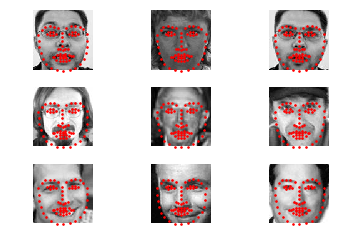

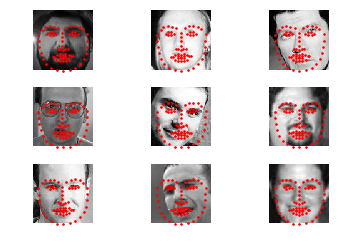

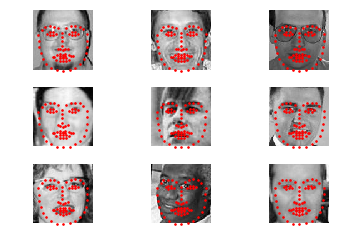

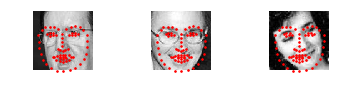

In [87]:
im_show(X_test, 30)

# Сравнение

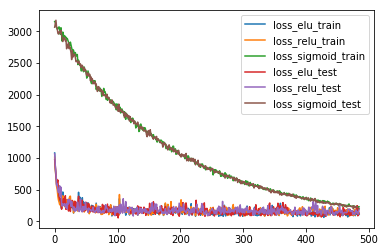

In [90]:
plt.plot(loss_list_elu[15:500], label='loss_elu_train')
plt.plot(loss_list_relu[15:500], label='loss_relu_train')
plt.plot(loss_list_sig[15:500], label='loss_sigmoid_train')
plt.plot(loss_list_elu_test[15:500], label='loss_elu_test')
plt.plot(loss_list_relu_test[15:500], label='loss_relu_test')
plt.plot(loss_list_sig_test[15:500], label='loss_sigmoid_test')
plt.legend()
plt.show()

## Вывод 2

Сигмоид сходится медленнее, так как производная вне окрестности нуля очень мала <br/>
К худшему качеству сошелся ReLU - видимо, потеряли часть информации <br/>
Лучше всего показал себя ELU - сошелся быстрее и к лучшему качеству

# ELU 1

In [91]:
model = nn.Sequential(nn.Linear(9216, 200), nn.ELU(), nn.Linear(200, 136))

In [92]:
loss_list_elu, loss_list_elu_test = learn_network(model, X_train, y_train, X_test, y_test, 1e-3, 7)

EPOCH 0
0 4836.92578125
EPOCH 1
0 1800.76013184
EPOCH 2
0 799.517944336
EPOCH 3
0 328.375396729
EPOCH 4
0 124.88356781
EPOCH 5
0 56.7047843933
EPOCH 6
0 20.8307304382


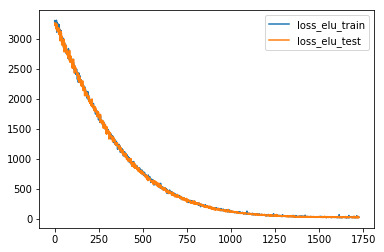

In [93]:
plt.plot(loss_list_elu[15:], label='loss_elu_train')
plt.plot(loss_list_elu_test[15:], label='loss_elu_test')
plt.legend()
plt.show()

In [94]:
loss(X_test, y_test)

Variable containing:
 20.2275
[torch.cuda.FloatTensor of size 1 (GPU 0)]

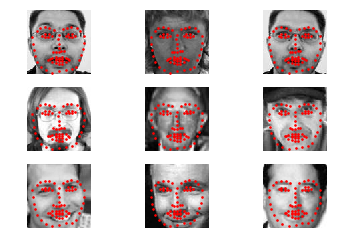

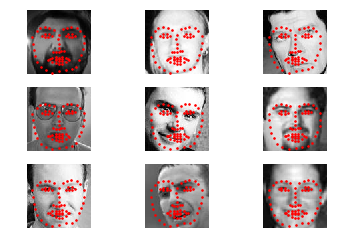

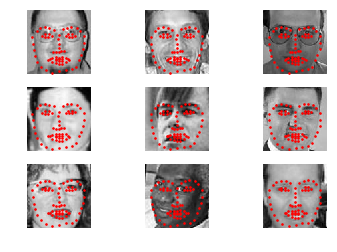

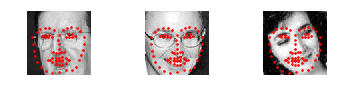

In [95]:
im_show(X_test, 30)

# ReLU 1

In [96]:
model = nn.Sequential(nn.Linear(9216, 200), nn.ReLU(), nn.Linear(200, 136))

In [97]:
loss_list_relu, loss_list_relu_test = learn_network(model, X_train, y_train, X_test, y_test, 1e-4, 8)

EPOCH 0
0 3833.29467773
EPOCH 1
0 188.769668579
EPOCH 2
0 142.640960693
EPOCH 3
0 144.340744019
EPOCH 4
0 98.6727828979
EPOCH 5
0 148.267349243
EPOCH 6
0 145.44442749
EPOCH 7
0 132.217163086


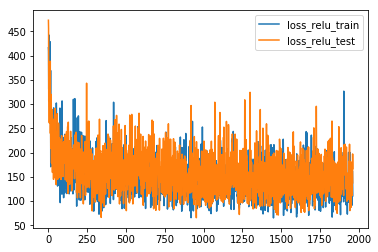

In [98]:
plt.plot(loss_list_relu[30:], label='loss_relu_train')
plt.plot(loss_list_relu_test[30:], label='loss_relu_test')
plt.legend()
plt.show()

In [99]:
loss(X_test, y_test)

Variable containing:
 139.6826
[torch.cuda.FloatTensor of size 1 (GPU 0)]

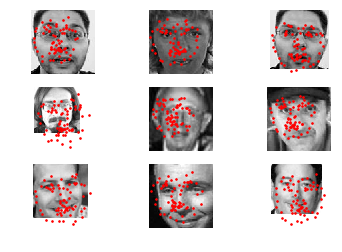

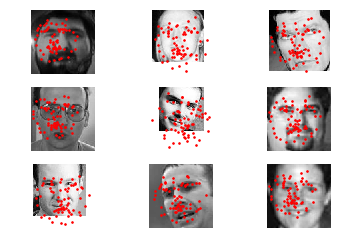

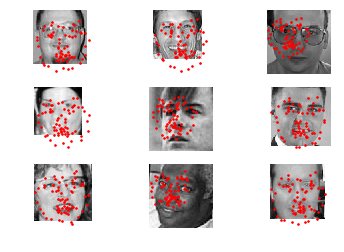

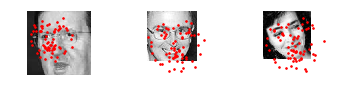

In [100]:
im_show(X_test, 30)

# Sigmoid 1

In [102]:
model = nn.Sequential(nn.Linear(9216, 200), nn.Sigmoid(), nn.Linear(200, 136))

In [103]:
loss_list_sig, loss_list_sig_test = learn_network(model, X_train, y_train, X_test, y_test, 1e-3, 8)

EPOCH 0
0 3178.31323242
EPOCH 1
0 1128.29992676
EPOCH 2
0 341.449279785
EPOCH 3
0 111.377845764
EPOCH 4
0 40.0532341003
EPOCH 5
0 18.358631134
EPOCH 6
0 18.8082542419
EPOCH 7
0 14.405755043


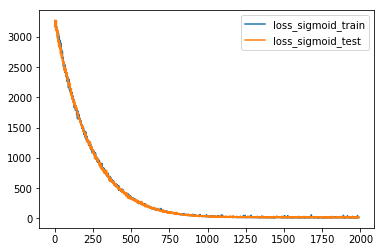

In [104]:
plt.plot(loss_list_sig, label='loss_sigmoid_train')
plt.plot(loss_list_sig_test, label='loss_sigmoid_test')
plt.legend()
plt.show()

In [105]:
loss(X_test, y_test)

RuntimeError: cuda runtime error (2) : out of memory at /pytorch/torch/lib/THC/generic/THCStorage.cu:66

In [111]:
im_show(X_test, 30)

RuntimeError: cuda runtime error (2) : out of memory at /pytorch/torch/lib/THC/generated/../generic/THCTensorMathPointwise.cu:247

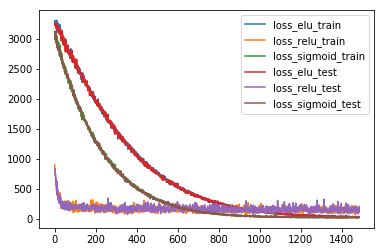

In [110]:
plt.plot(loss_list_elu[15:1500], label='loss_elu_train')
plt.plot(loss_list_relu[15:1500], label='loss_relu_train')
plt.plot(loss_list_sig[15:1500], label='loss_sigmoid_train')
plt.plot(loss_list_elu_test[15:1500], label='loss_elu_test')
plt.plot(loss_list_relu_test[15:1500], label='loss_relu_test')
plt.plot(loss_list_sig_test[15:1500], label='loss_sigmoid_test')
plt.legend()
plt.show()

## Вывод 3

Быстро сошелся ELU, но к плохому качеству <br/>
Сигмоид сходится медленнее, но к лучшему качеству <br/>
В этот раз ELU сошелся медленнее сигмоида, но к такому же качеству <br/>